# Notebook version of mems.py for incremental visualization

In [1]:
import gdsfactory as gf
gf.gpdk.PDK.activate()  # Placeholder until custom PDK is implemented

# Physical Definitions:
# Young's Modulus Doped PolySi, E: 160 GPa
# Spring/Comb Width,            b: 0.5 um
# Thickness Doped PolySi,       t: 1.5 um
# Length of Spring,             L: 60 um
# Gap of Comb,                  g: 0.3 um
# Voltage of Comb,              V: 10 V
# Permittivity of Free-Space,   e: 8.854 pF/m
# Displacement of Shuttle,      x: 0.55 um
# Number of Combs per CD,       n: 40

# Layers — TODO update once custom PDK created
DPOLY   = (1, 0)  # doped poly-Si (structural MEMS)
PSG     = (2, 0)  # phosphosilicate glass (sacrificial)
UDPOLY  = (3, 0)  # undoped poly-Si (anchor)
UDOXIDE = (4, 0)  # undoped oxide (LTO)
METAL   = (5, 0)  # metal
SOI     = (6, 0)  # SOI silicon


def make_etch_hole(size=10.0, margin=0.5, layer=DPOLY):
    """Single square etch hole with margin offset from origin.

    Args:
        size:   Side length of the hole (um).
        margin: Offset from (0,0) so the hole is inset within a grid cell.
        layer:  GDS layer for the hole polygon.

    Returns:
        gf.Component with one square polygon.
    """
    c = gf.Component()
    c.add_polygon(
        [(margin, margin),
         (margin + size, margin),
         (margin + size, margin + size),
         (margin, margin + size)],
        layer=layer,
    )
    return c

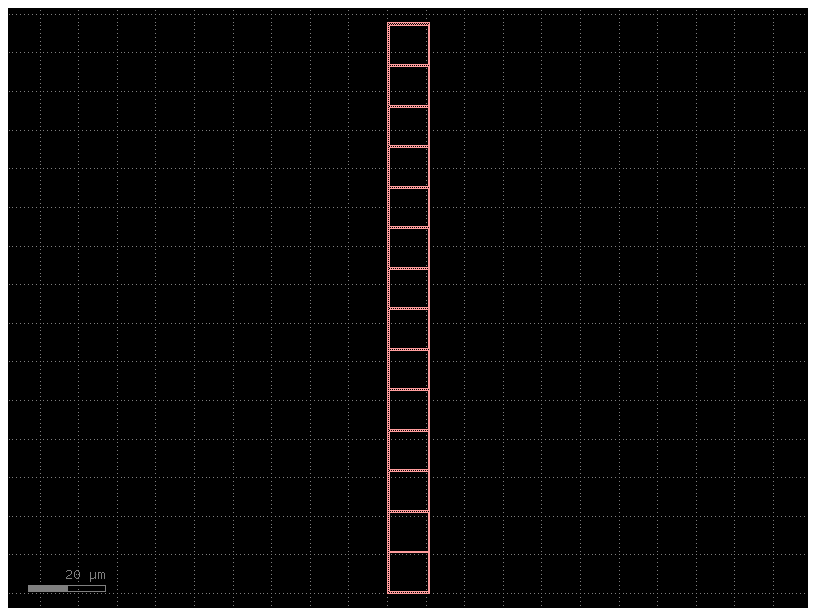

In [2]:
def make_shuttle(
    n_holes: int = 14,
    hole_size: float = 10.0,
    hole_margin: float = 0.5,
    hole_pitch: float = 10.5,
    top_margin: float = 1.0,
    layer=DPOLY,
):
    """Shuttle body with longitudinal etch-hole array.

    The outline width and height are derived from the hole parameters:
        width  = hole_size + 2 * hole_margin
        height = (n_holes - 1) * hole_pitch + hole_size + hole_margin + top_margin

    Args:
        n_holes:     Number of etch holes along the shuttle length.
        hole_size:   Side length of each square etch hole (um).
        hole_margin: Minimum margin between hole edge and shuttle edge (um).
        hole_pitch:  Center-to-center spacing of etch holes (um).
        top_margin:  Extra margin at the top of the shuttle (um).
        layer:       GDS layer.

    Returns:
        gf.Component of the shuttle (outline minus etch holes).
    """
    width  = hole_size + 2 * hole_margin
    height = (n_holes - 1) * hole_pitch + hole_size + hole_margin + top_margin

    outline = gf.Component()
    outline.add_polygon(
        [(0, 0), (width, 0), (width, height), (0, height)],
        layer=layer,
    )

    etch_hole = make_etch_hole(size=hole_size, margin=hole_margin, layer=layer)

    holes = gf.Component()
    holes.add_ref(etch_hole, columns=1, rows=n_holes,
                  column_pitch=hole_pitch, row_pitch=hole_pitch)

    shuttle = gf.boolean(
        A=outline, B=holes, operation="not",
        layer1=layer, layer2=layer, layer=layer,
    )
    return shuttle


shuttle = make_shuttle()
shuttle.plot()

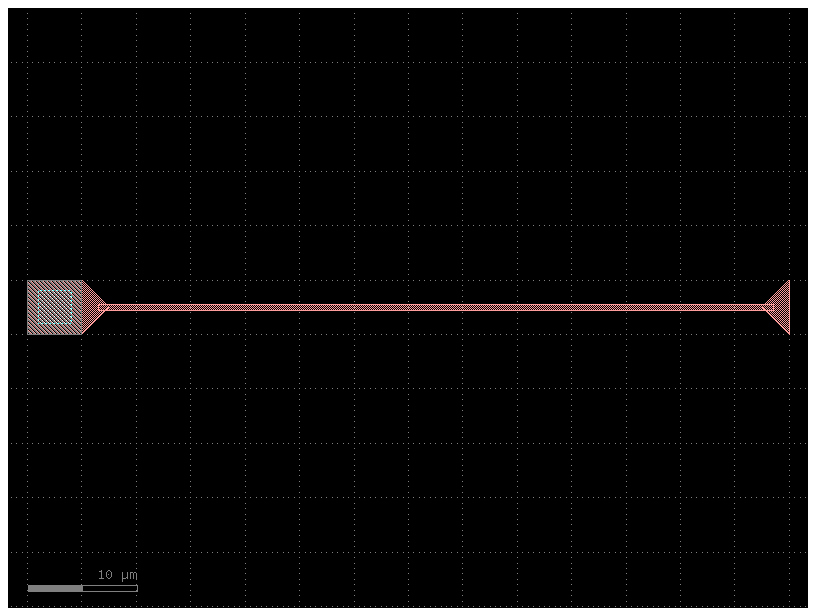

In [3]:
def make_spring(
    anchor_w: float = 5.0,
    anchor_h: float = 5.0,
    chevron_ext: float = 2.5,
    psg_inset: float = 1.0,
    arm_width: float = 0.5,
    arm_length: float = 62.0,
    arm_gap: float = 1.5,
    terminal_depth: float = 2.5,
    terminal_overlap: float = 1.0,
    struct_layer=DPOLY,
    sac_layer=PSG,
    anchor_poly_layer=UDPOLY,
    anchor_si_layer=SOI,
):
    """Folded-spring element: anchor + flexure arm + triangular terminal.

    Geometry (left to right):
        Anchor: rectangle (anchor_w x anchor_h) with a chevron tip extending
                chevron_ext past the right edge.  PSG/UDPOLY/SOI anchor pads
                are placed underneath.
        Arm:    Thin beam of width arm_width starting arm_gap past the anchor
                right edge, running for arm_length.
        Terminal: Right-pointing triangle connecting the arm tip to the shuttle.

    Args:
        anchor_w:          Anchor base rectangle width (um).
        anchor_h:          Anchor base rectangle height (um).
        chevron_ext:       How far the chevron tip extends past anchor_w (um).
        psg_inset:         Inset of PSG release window from anchor edges (um).
        arm_width:         Width of the flexure arm (um).
        arm_length:        Length of the flexure arm (um).
        arm_gap:           Gap between anchor right edge and arm start (um).
        terminal_depth:    X-extent of the triangular terminal (um).
        terminal_overlap:  How far the terminal tip overlaps back over the arm end (um).
        struct_layer:      Layer for structural poly-Si.
        sac_layer:         Layer for sacrificial PSG.
        anchor_poly_layer: Layer for undoped anchor poly.
        anchor_si_layer:   Layer for SOI anchor.
    """
    spring = gf.Component()
    mid_y = anchor_h / 2

    # --- Anchor ---
    anchor = gf.Component()
    # Pentagon: rectangle + chevron tip
    anchor.add_polygon(
        [(0, 0),
         (anchor_w, 0),
         (anchor_w + chevron_ext, mid_y),
         (anchor_w, anchor_h),
         (0, anchor_h)],
        layer=struct_layer,
    )
    # PSG release window
    anchor.add_polygon(
        [(psg_inset, psg_inset),
         (anchor_w - psg_inset, psg_inset),
         (anchor_w - psg_inset, anchor_h - psg_inset),
         (psg_inset, anchor_h - psg_inset)],
        layer=sac_layer,
    )
    # Anchor pads (full rectangle on undoped poly and SOI)
    anchor_rect = [(0, 0), (anchor_w, 0), (anchor_w, anchor_h), (0, anchor_h)]
    anchor.add_polygon(anchor_rect, layer=anchor_poly_layer)
    anchor.add_polygon(anchor_rect, layer=anchor_si_layer)

    # --- Flexure arm ---
    arm = gf.Component()
    arm_x0 = anchor_w + arm_gap
    arm_y0 = mid_y - arm_width / 2
    arm_x1 = arm_x0 + arm_length
    arm_y1 = arm_y0 + arm_width
    arm.add_polygon(
        [(arm_x0, arm_y0), (arm_x1, arm_y0), (arm_x1, arm_y1), (arm_x0, arm_y1)],
        layer=struct_layer,
    )

    # --- Triangular terminal ---
    terminal = gf.Component()
    tip_x = arm_x1 - terminal_overlap
    end_x = tip_x + terminal_depth
    terminal.add_polygon(
        [(tip_x, mid_y), (end_x, 0), (end_x, anchor_h)],
        layer=struct_layer,
    )

    spring.add_ref(anchor)
    spring.add_ref(arm)
    spring.add_ref(terminal)
    return spring


spring = make_spring()
spring.plot()

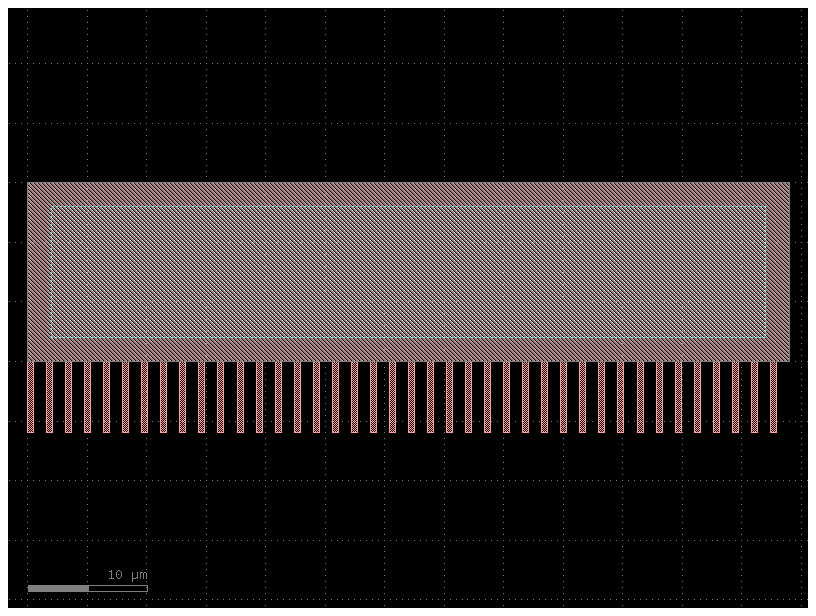

In [4]:
def make_fixed_comb_drive(
    n_fingers: int = 40,
    finger_width: float = 0.5,
    finger_gap: float = 0.3,
    finger_length: float = 6.0,
    anchor_height: float = 15.0,
    psg_inset: float = 2.0,
    struct_layer=DPOLY,
    sac_layer=PSG,
    anchor_poly_layer=UDPOLY,
    anchor_si_layer=SOI,
):
    """Fixed (stator) comb drive: anchor pad with downward-hanging finger array.

    Finger geometry:
        pitch = 2 * finger_width + 2 * finger_gap
        anchor_width = n_fingers * pitch  (array spans full anchor)

    Args:
        n_fingers:         Number of comb fingers.
        finger_width:      Width of each finger (um).
        finger_gap:        Lateral gap between adjacent fingers (um).
        finger_length:     Length of each finger (um).
        anchor_height:     Height of the anchor pad (um).
        psg_inset:         Inset of PSG window from anchor edges (um).
        struct_layer:      Structural poly-Si layer.
        sac_layer:         Sacrificial PSG layer.
        anchor_poly_layer: Undoped poly anchor layer.
        anchor_si_layer:   SOI anchor layer.
    """
    pitch = 2 * finger_width + 2 * finger_gap
    anchor_width = n_fingers * pitch

    cd = gf.Component()

    # --- Anchor ---
    anchor = gf.Component()
    anchor_rect = [(0, 0), (anchor_width, 0),
                   (anchor_width, anchor_height), (0, anchor_height)]
    anchor.add_polygon(anchor_rect, layer=struct_layer)
    anchor.add_polygon(
        [(psg_inset, psg_inset),
         (anchor_width - psg_inset, psg_inset),
         (anchor_width - psg_inset, anchor_height - psg_inset),
         (psg_inset, anchor_height - psg_inset)],
        layer=sac_layer,
    )
    anchor.add_polygon(anchor_rect, layer=anchor_poly_layer)
    anchor.add_polygon(anchor_rect, layer=anchor_si_layer)

    # --- Fingers (hanging downward from y=0) ---
    finger = gf.Component()
    finger.add_polygon(
        [(0, 0), (0, -finger_length),
         (finger_width, -finger_length), (finger_width, 0)],
        layer=struct_layer,
    )

    cd.add_ref(anchor)
    cd.add_ref(finger, columns=n_fingers, rows=1,
               column_pitch=pitch, row_pitch=pitch)
    return cd


cd = make_fixed_comb_drive()
cd.plot()

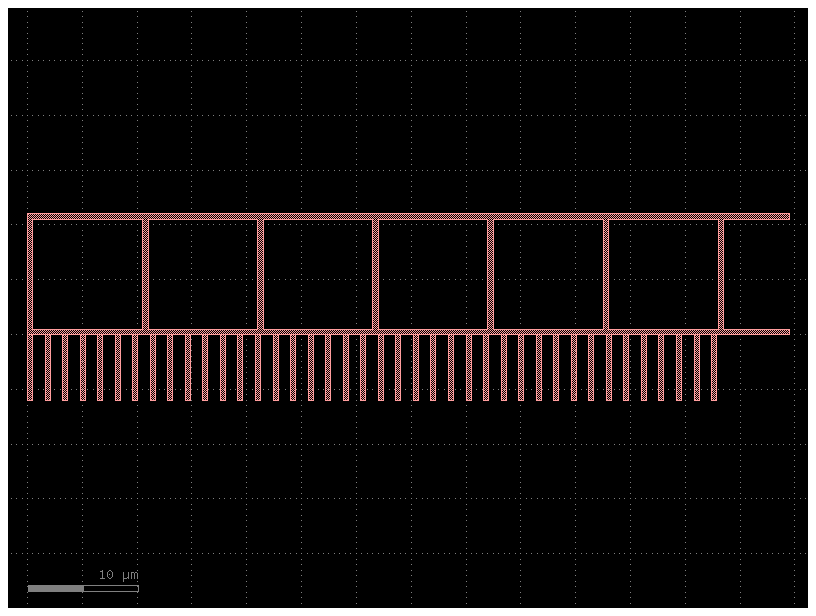

In [5]:
def make_moving_comb_drive(
    n_fingers: int = 40,
    finger_width: float = 0.5,
    finger_gap: float = 0.3,
    finger_length: float = 6.0,
    anchor_width: float = 69.5,
    anchor_height: float = 11.0,
    n_hole_cols: int = 7,
    hole_size: float = 10.0,
    hole_margin: float = 0.5,
    hole_pitch: float = 10.5,
    struct_layer=DPOLY,
):
    """Moving (rotor) comb drive: anchor slab with etch holes + downward finger array.

    The anchor is attached to the shuttle and freed during release, so it has
    no PSG/UDPOLY/SOI anchor pads — only structural DPOLY with etch holes.

    Args:
        n_fingers:    Number of comb fingers.
        finger_width: Width of each finger (um).
        finger_gap:   Lateral gap between fingers (um).
        finger_length:Length of each finger (um).
        anchor_width: Width of the moving anchor slab (um).
        anchor_height:Height of the moving anchor slab (um).
        n_hole_cols:  Number of etch-hole columns in the anchor.
        hole_size:    Etch hole side length (um).
        hole_margin:  Etch hole inset from (0,0) (um).
        hole_pitch:   Etch hole pitch (um).
        struct_layer: Structural poly-Si layer.
    """
    pitch = 2 * finger_width + 2 * finger_gap

    # --- Anchor outline ---
    anchor_outline = gf.Component()
    anchor_outline.add_polygon(
        [(0, 0), (anchor_width, 0),
         (anchor_width, anchor_height), (0, anchor_height)],
        layer=struct_layer,
    )

    # --- Etch holes ---
    etch_hole = make_etch_hole(size=hole_size, margin=hole_margin, layer=struct_layer)
    holes = gf.Component()
    holes.add_ref(etch_hole, columns=n_hole_cols, rows=1,
                  column_pitch=hole_pitch, row_pitch=hole_pitch)

    cd_mov = gf.boolean(
        A=anchor_outline, B=holes, operation="not",
        layer1=struct_layer, layer2=struct_layer, layer=struct_layer,
    )

    # --- Fingers ---
    finger = gf.Component()
    finger.add_polygon(
        [(0, 0), (0, -finger_length),
         (finger_width, -finger_length), (finger_width, 0)],
        layer=struct_layer,
    )

    cd_mov.add_ref(finger, columns=n_fingers, rows=1,
                   column_pitch=pitch, row_pitch=pitch)
    return cd_mov


cd_mov = make_moving_comb_drive()
cd_mov.plot()

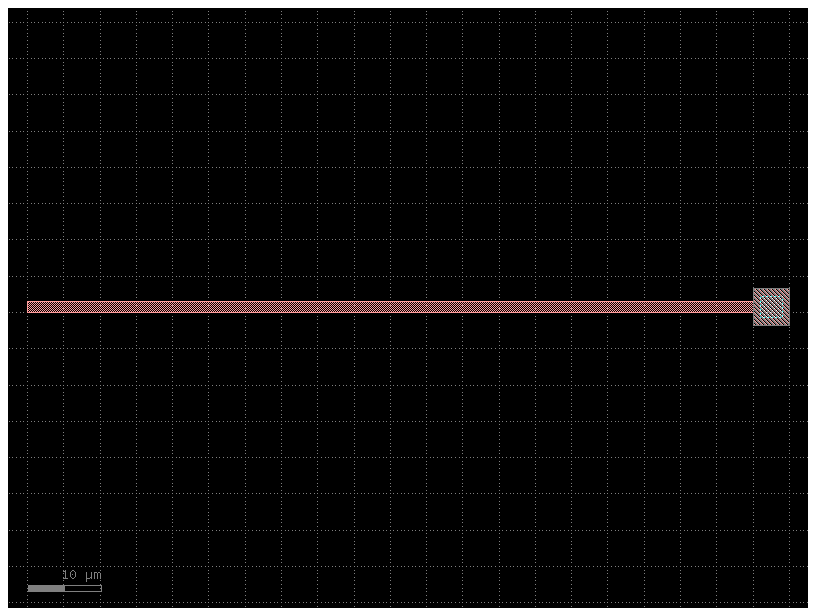

In [6]:
def make_interconnect(
    beam_length: float = 50.0,
    beam_width: float = 1.5,
    anchor_size: float = 5.0,
    psg_inset: float = 1.0,
    struct_layer=DPOLY,
    sac_layer=PSG,
    anchor_si_layer=SOI,
):
    """Interconnect: horizontal beam terminated with an anchored pad.

    The beam runs from x=0 to x=beam_length.  An anchor pad of
    anchor_size x anchor_size is appended at the far end, centred
    vertically on the beam.

    Args:
        beam_length:    Length of the interconnect beam (um).
        beam_width:     Width of the interconnect beam (um).
        anchor_size:    Side length of the square anchor pad (um).
        psg_inset:      Inset of PSG window inside the anchor (um).
        struct_layer:   Structural poly-Si layer.
        sac_layer:      Sacrificial PSG layer.
        anchor_si_layer:SOI anchor layer.
    """
    ic = gf.Component()
    beam_mid_y = beam_width / 2

    # --- Beam ---
    ic.add_polygon(
        [(0, 0), (beam_length, 0),
         (beam_length, beam_width), (0, beam_width)],
        layer=struct_layer,
    )

    # --- Anchor pad (centred on beam) ---
    anchor = gf.Component()
    ax0 = beam_length
    ax1 = beam_length + anchor_size
    ay0 = beam_mid_y - anchor_size / 2
    ay1 = beam_mid_y + anchor_size / 2
    anchor_rect = [(ax0, ay0), (ax1, ay0), (ax1, ay1), (ax0, ay1)]
    anchor.add_polygon(anchor_rect, layer=struct_layer)
    anchor.add_polygon(anchor_rect, layer=anchor_si_layer)

    # PSG window
    anchor.add_polygon(
        [(ax0 + psg_inset, ay0 + psg_inset),
         (ax1 - psg_inset, ay0 + psg_inset),
         (ax1 - psg_inset, ay1 - psg_inset),
         (ax0 + psg_inset, ay1 - psg_inset)],
        layer=sac_layer,
    )

    ic.add_ref(anchor)
    return ic


interconnect      = make_interconnect(beam_length=50.0)
interconnect_long = make_interconnect(beam_length=100.0)
interconnect_long.plot()

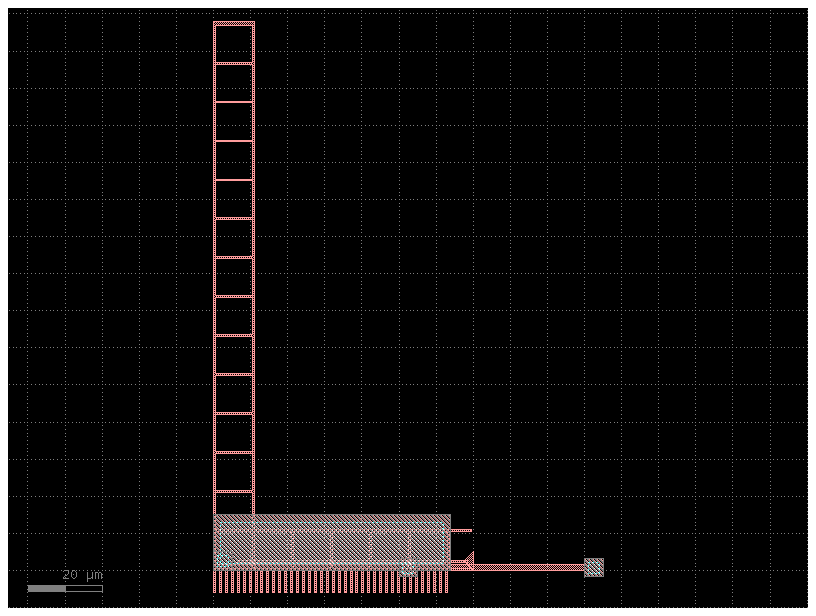

In [7]:
# Assemble MEMS Components
mems = gf.Component()

mems.add_ref(shuttle)

s1a = mems.add_ref(spring)
s1b = mems.add_ref(spring)
s2a = mems.add_ref(spring)
s2b = mems.add_ref(spring)

cd1a = mems.add_ref(cd)
cd1b = mems.add_ref(cd)
cd2a = mems.add_ref(cd)
cd2b = mems.add_ref(cd)

cdm1a = mems.add_ref(cd_mov)
cdm1b = mems.add_ref(cd_mov)
cdm2a = mems.add_ref(cd_mov)
cdm2b = mems.add_ref(cd_mov)

ic1 = mems.add_ref(interconnect)
ic2 = mems.add_ref(interconnect)
ic3 = mems.add_ref(interconnect)
ic4 = mems.add_ref(interconnect_long)

mems.plot()


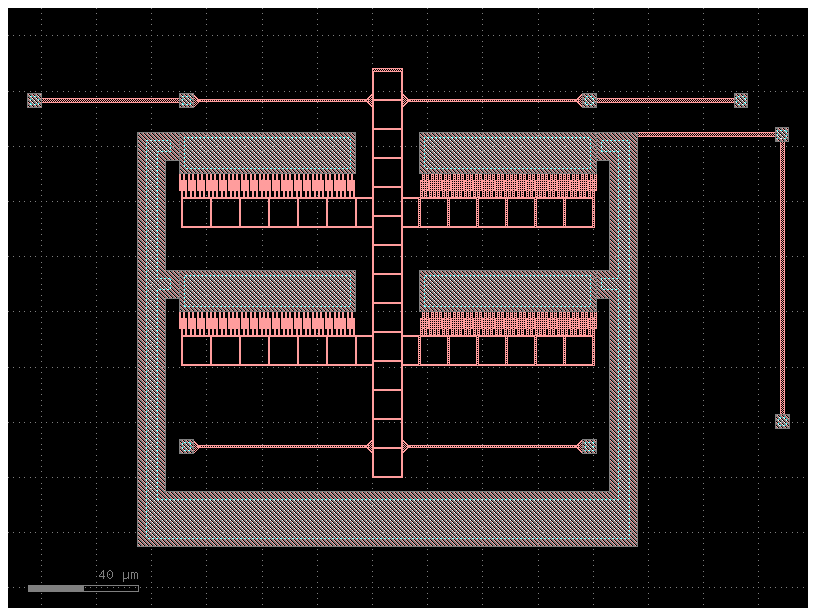

In [8]:
# Move Springs
s1a.move(origin=(0, 0), destination=(-70, 134))
s2a.move(origin=(0, 0), destination=(-70, 8.5))
s1b.mirror_x().move(origin=(0, 0), destination=(81, 134))
s2b.mirror_x().move(origin=(0, 0), destination=(81, 8.5))

# Move Fixed Comb Drives
cd1a.move(origin=(0, 0), destination=(-70, 110))
cd2a.move(origin=(0, 0), destination=(-70, 60))
cd1b.mirror_x().move(origin=(0, 0), destination=(81, 110))
cd2b.mirror_x().move(origin=(0, 0), destination=(81, 60))

# Move Moving Comb Drives
cdm1a.mirror_y().move(origin=(0, 0), destination=(-69.25, 101.5))
cdm2a.mirror_y().move(origin=(0, 0), destination=(-69.25, 51.5))
cdm1b.mirror_x().mirror_y().move(origin=(0, 0), destination=(80.25, 101.5))
cdm2b.mirror_x().mirror_y().move(origin=(0, 0), destination=(80.25, 51.5))

# Move Interconnects
ic1.move(origin=(0, 0), destination=(81, 135.75))
ic2.mirror_x().move(origin=(0, 0), destination=(-70, 135.75))
ic3.move(origin=(0, 0), destination=(96, 123.5))
ic4.move(origin=(0, 0.75), destination=(148.5, 122.75)).rotate(
    angle=-90, center=(148.5, 122.75)
)


def make_comb_drive_node(
    right_inner: float = 81.0,
    right_outer: float = 96.0,
    left_inner: float = -70.0,
    left_outer: float = -85.0,
    top_y: float = 125.0,
    bot_outer: float = -25.0,
    bot_inner: float = -5.0,
    notch_depth: float = 5.0,
    notch_lo: float = 65.0,
    notch_hi: float = 75.0,
    notch2_lo: float = 115.0,
    notch2_hi: float = 125.0,
    psg_inset: float = 3.0,
    psg_inset_ri: float = 2.0,
    struct_layer=DPOLY,
    sac_layer=PSG,
    anchor_si_layer=SOI,
):
    """Comb-drive node: U-shaped frame electrically connecting all fixed comb drives.

    The frame surrounds the shuttle on three sides (left, bottom, right) with
    notches cut out where the comb-drive anchors sit.

    The polygon is traced clockwise starting from the top-right inner corner.

    Args:
        right_inner:    Inner x-coordinate on the right side (um).
        right_outer:    Outer x-coordinate on the right side (um).
        left_inner:     Inner x-coordinate on the left side (um).
        left_outer:     Outer x-coordinate on the left side (um).
        top_y:          Top y-coordinate of the frame (um).
        bot_outer:      Outer bottom y-coordinate (um).
        bot_inner:      Inner bottom y-coordinate (um).
        notch_depth:    How far each notch extends inward from the inner edge (um).
        notch_lo:       Lower y-bound of the lower notch pair (um).
        notch_hi:       Upper y-bound of the lower notch pair (um).
        notch2_lo:      Lower y-bound of the upper notch pair (um).
        notch2_hi:      Upper y-bound of the upper notch pair (um).
        psg_inset:      General PSG inset from DPOLY edges (um).
        psg_inset_ri:   PSG inset at the right-inner edge (um).
                        The original layout uses 2 um here vs 3 um elsewhere.
        struct_layer:   Structural poly-Si layer.
        sac_layer:      Sacrificial PSG layer.
        anchor_si_layer:SOI anchor layer.
    """
    ri = right_inner
    ro = right_outer
    li = left_inner
    lo = left_outer
    nd = notch_depth

    # Clockwise from top-right inner corner
    dpoly_pts = [
        (ri, top_y), (ro, top_y), (ro, bot_outer), (lo, bot_outer),
        (lo, top_y), (li, top_y),
        # Left upper notch
        (li, notch2_lo), (li - nd, notch2_lo),
        (li - nd, notch_hi), (li, notch_hi),
        # Left lower notch
        (li, notch_lo), (li - nd, notch_lo),
        (li - nd, bot_inner), (ri + nd, bot_inner),
        # Right lower notch
        (ri + nd, notch_lo), (ri, notch_lo),
        (ri, notch_hi), (ri + nd, notch_hi),
        # Right upper notch
        (ri + nd, notch2_lo), (ri, notch2_lo),
    ]

    # PSG inset version — each vertex offset inward into the frame material.
    # General inset p applies everywhere; right-inner edge uses p_ri instead.
    p = psg_inset
    p_ri = psg_inset_ri
    psg_pts = [
        # Outer frame
        (ri + p_ri, top_y - p), (ro - p, top_y - p),
        (ro - p, bot_outer + p), (lo + p, bot_outer + p),
        (lo + p, top_y - p), (li - p, top_y - p),
        # Left upper notch
        (li - p, notch2_lo + p), (li - nd - p, notch2_lo + p),
        (li - nd - p, notch_hi - p), (li - p, notch_hi - p),
        # Left lower notch
        (li - p, notch_lo + p), (li - nd - p, notch_lo + p),
        (li - nd - p, bot_inner - p), (ri + nd + p, bot_inner - p),
        # Right lower notch
        (ri + nd + p, notch_lo + p), (ri + p_ri, notch_lo + p),
        (ri + p_ri, notch_hi - p), (ri + nd + p, notch_hi - p),
        # Right upper notch
        (ri + nd + p, notch2_lo + p), (ri + p_ri, notch2_lo + p),
    ]

    cdn = gf.Component()
    cdn.add_polygon(dpoly_pts, layer=struct_layer)
    cdn.add_polygon(psg_pts, layer=sac_layer)
    cdn.add_polygon(dpoly_pts, layer=anchor_si_layer)
    return cdn


cdn = make_comb_drive_node()
mems.add_ref(cdn)

mems.plot()
